In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms,models
import pandas as pd
from PIL import Image
import itertools
from IPython.display import display
import os
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pd.set_option('display.max_rows', 301)

In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


Tesla P100-PCIE-16GB


In [4]:
#For plotting confusion matrix in kaggle kernel 
#Credit: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Handling Image Input from Dataset
### Performing Operations: Dataload,Transform,Split, Compose(Normalize,Resize,Random-Flip,Crop etc.)

In [5]:
train_transform = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomHorizontalFlip(), #default probabily
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])                            
])

test_transform = transforms.Compose([
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485,0.456,0.406], 
                        [0.229,0.224,0.225])                                 
])

In [6]:
root = '../input/fire-smoke-and-neutral/FIRE-SMOKE-DATASET/'
#Using image folder (0f torchvision)
train_data = datasets.ImageFolder(os.path.join(root,'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'Test'), transform=test_transform)

torch.manual_seed(42)

#data loader
train_loader = DataLoader(train_data, batch_size=10, shuffle= True)
test_loader = DataLoader(test_data, batch_size=10,shuffle= True)


class_names = train_data.classes
print(class_names)

['Fire', 'Neutral', 'Smoke']


#### C.Name   -   Index
#### Fire    -->   0
#### Neutral -->   1
#### Smoke   -->   2

In [ ]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

In [ ]:
for images, labels in train_loader:
      break

In [ ]:
images.shape 
#output (#images per batch, #channels, dimensions)

In [ ]:
#For viewing original image on plt.imshow
#Denormalized
#to understand how normalization applied
inverse_normalized = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], 
                                      std=[1/0.229,1/0.224,1/0.225])
# image_inv = inverse_normalized(NORMALIZED_IMAGE)
# plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [ ]:
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 5)
inv_normalized = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], 
                                      std=[1/0.229,1/0.224,1/0.225])
im_inv = inv_normalized(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # In Channels -> 3 
        # Out channels -> 6
        # Filter -> 3x3
        # Stride -> 1
        self.conv1 = nn.Conv2d(3,6,3,1)

        # In Channels -> 6 
        # Out channels -> 16
        # Filter -> 3x3
        # Stride -> 1
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        # **Adding another convulotional layer**
        # In Channels -> 16
        # Out channels -> 26
        # Filter -> 3x3
        # Stride -> 1
        self.conv3 = nn.Conv2d(16,26,3,1)
        
        # **Adding another convulotional layer**
        # In Channels -> 26
        # Out channels -> 36
        # Filter -> 3x3
        # Stride -> 1
        self.conv4 = nn.Conv2d(26,36,3,1)
        
        
        # **Adding another convulotional layer**
        # In Channels -> 36
        # Out channels -> 
        # Filter -> 3x3
        # Stride -> 1
        self.conv5 = nn.Conv2d(36,48,3,1)

        
    # input calculation -> Floor(((((((((224-2)/2)-2)/2)-2)/2)-2)/2)-2)/2  = 5 
    #(-2 for each filter with no padding)
    # (/2 for each pooling)
        self.fc1 = nn.Linear(5*5*48,512) 
        self.fc2 = nn.Linear(512,256) 
        self.fc3 = nn.Linear(256,80)
        self.fc4 = nn.Linear(80,3)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = X.view(-1, 5*5*48)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)

        return F.log_softmax(X, dim=1)

In [ ]:
#Hyper parameters
SEED = 101
LEARNING_RATE = 0.001
EPOCHS = 9
MAX_BATCH_SIZE = 9999999 #unlimited (whole dataset)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

#CNN Model
modelCNN = ConvNetwork()
modelCNN = modelCNN.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr= LEARNING_RATE)

In [ ]:
modelCNN

In [ ]:
total_params = 0
for parameters in modelCNN.parameters():
  print(parameters.numel())
  total_params += parameters.numel()
print(f"Total params: {total_params} ")

In [ ]:
start_time = time.time()

#Limiting batch sizes
max_trn_batch = MAX_BATCH_SIZE #1800 
max_tst_batch = MAX_BATCH_SIZE #300 

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(EPOCHS):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        #Limiting batch sizes for testing the model (if required)
        if b==max_trn_batch:
            break     
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        b+=1
        y_pred = modelCNN(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing correct predictions (training)
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%70 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} Training accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
      
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            if( b==max_tst_batch):
                break
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelCNN(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {(total_time/60):.2f} mins')

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [ ]:
print(test_correct)
test_data_size = len(test_data)
print(f'Test accuracy: {test_correct[-1].item()*100/test_data_size:.2f}%')

In [ ]:
for i,acc in enumerate(test_correct):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/test_data_size:.2f}%')

In [ ]:
# Manual evaluation on test set
modelCNN.eval()
corr_pred = 0
act = []
pred = []

for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelCNN(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(class_names[labs[i].item()])
        pred.append(class_names[new_pred.item()])
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (CNN): {corr_pred} ")
print(f"\nTest Set Accuracy (CNN): {100*corr_pred/len(test_data):.2f}% ")

In [ ]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for Custom CNN")

In [ ]:
#Testing a single image
img_index = 50
#test data already transformed and normalized (denormalized to view them in plt.imshow)
im_test = inverse_normalized(test_data[img_index][0]) 
plt.imshow(np.transpose(im_test.numpy(), (1,2,0)))

In [ ]:
# Evaluating model with a single image from dataset
modelCNN.eval() 

with torch.no_grad():
    new_pred = modelCNN(test_data[img_index][0].view(1,3,224,224).cuda()).argmax()

print(f'Predicted class: {class_names[new_pred.item()]}')

# Pre-trained Models
1. Alexnet
2. Resnet
3. VGG-16
4. Googlenet

## 1. Alexnet

In [ ]:
modelAlexnet = models.alexnet(pretrained=True)
#Freezing pretrained parameters (w,b)

for param in modelAlexnet.parameters():
    param.requires_grad = False

In [ ]:
modelAlexnet

In [ ]:
#Hyperparams
ALEXLR = 0.001
ALEXEPOCH = 4
ALEXSEED = 42
ALEXDROPOUT  = 0.5
ALEX_MAX_BATCH_SIZE = 99999999
torch.manual_seed(ALEXSEED)
torch.cuda.manual_seed(ALEXSEED)

#Modifying the classicification section 
modelAlexnet.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(ALEXDROPOUT),
                                       nn.Linear(1024,512),
                                       nn.ReLU(),
                                       nn.Linear(512,256),
                                       nn.ReLU(),
                                       nn.Linear(256,3),
                                       nn.LogSoftmax(dim=1))

modelAlexnet = modelAlexnet.cuda()

In [ ]:
modelAlexnet

In [ ]:
total_params = 0
for parameters in modelAlexnet.parameters():
  print(parameters.numel())
  total_params += parameters.numel()
print(f"Total params (alexnet): {total_params/1000000} mil")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelAlexnet.classifier.parameters(), lr=ALEXLR)

In [ ]:
modelAlexnet.train()
start_time = time.time()

#Limiting batch sizes
max_trn_batch = ALEX_MAX_BATCH_SIZE #600 
max_tst_batch = ALEX_MAX_BATCH_SIZE #200 

# Tracking losses
train_losses_anet = []
test_losses_anet = []
train_correct_anet = []
test_correct_anet = []


for i in range(ALEXEPOCH):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
            
          #Limiting batch sizes for testing the model
        if b==max_trn_batch:
            break

        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        b+=1
        y_pred = modelAlexnet(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%10 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
      
    train_losses_anet.append(loss)
    train_correct_anet.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            if( b==max_tst_batch):
                break
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelAlexnet(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses_anet.append(loss)
    test_correct_anet.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

In [ ]:
plt.plot(train_losses_anet, label='training loss')
plt.plot(test_losses_anet, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [ ]:
print(test_correct_anet)
test_data_size = len(test_data)
print(f'Test accuracy: {test_correct_anet[-1].item()*100/test_data_size:.2f}%')

In [ ]:
for i,acc in enumerate(test_correct_anet):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/test_data_size:.2f}%')

In [ ]:
#Testing a single image
img_index = 73
#test data already transformed and normalized (denormalized to view them in plt.imshow)
im_test = inverse_normalized(test_data[img_index][0]) 
plt.imshow(np.transpose(im_test.numpy(), (1,2,0)))

In [ ]:
# Evaluating model with a single image from dataset
modelAlexnet.eval() 

with torch.no_grad():
    new_pred = modelAlexnet(test_data[img_index][0].view(1,3,224,224).cuda()).argmax()

print(f'Predicted class: {class_names[new_pred.item()]}')

In [ ]:
# Manual evaluation on test set
modelAlexnet.eval()
corr_pred = 0
act = []
pred = []

for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelAlexnet(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(class_names[labs[i].item()])
        pred.append(class_names[new_pred.item()])
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (ALEXNET): {corr_pred} ")
print(f"\nTest Set Accuracy (ALEXNET): {100*corr_pred/len(test_data):.2f}% ")

#Print as dataframe
# evalDict = {}
# evalDict['Actual'] = act
# evalDict['Predicted'] = pred
# evalDf = pd.DataFrame(evalDict)
# #evalDf.head(300)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for ALEXNET")

# 2. Resnet


In [7]:
modelResnet = models.resnet18(pretrained=True)

for param in modelResnet.parameters():
    param.requires_grad = False

In [8]:
default_infeatures = modelResnet.fc.in_features
modelResnet.fc = nn.Linear(default_infeatures, len(class_names))
modelResnet.fc

Linear(in_features=512, out_features=3, bias=True)

In [9]:
total_params = 0
for parameters in modelResnet.parameters():
  #print(parameters.numel())
  total_params += parameters.numel()
print(f"Total params (alexnet): {total_params/1000000} mil")

Total params (alexnet): 11.178051 mil


In [10]:
modelResnet = modelResnet.to(device)

In [11]:
#Hyper parameters
resLR = 0.001
resMomentum = 0.9
resStepSize = 5
resGamma = 0.1
resEPOCH = 15
RESSEED = 101

torch.manual_seed(RESSEED)
torch.cuda.manual_seed(RESSEED)

criterion = nn.CrossEntropyLoss()
#SGD as optimizer with lr and momentum
optimizer = torch.optim.SGD(modelResnet.fc.parameters(), lr= resLR, momentum= resMomentum)
# Exponential learning rate
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = resStepSize, gamma = resGamma)

In [12]:
modelResnet.train()

start_time = time.time()

# Tracking losses
train_losses_resnet = []
test_losses_resnet = []
train_correct_resnet = []
test_correct_resnet = []


for i in range(resEPOCH):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
            
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        b+=1
        y_pred = modelResnet(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%70 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
    
    exp_lr_scheduler.step() 
    train_losses_resnet.append(loss)
    train_correct_resnet.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelResnet(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses_resnet.append(loss)
    test_correct_resnet.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:1 Batch:70 Loss:0.4557889 accuracy: 71.286% 
Epoch:1 Batch:140 Loss:0.1221146 accuracy: 77.929% 
Epoch:1 Batch:210 Loss:0.4939698 accuracy: 80.667% 
Epoch:2 Batch:70 Loss:0.1801021 accuracy: 86.286% 
Epoch:2 Batch:140 Loss:0.5934211 accuracy: 87.571% 
Epoch:2 Batch:210 Loss:0.3427553 accuracy: 88.762% 
Epoch:3 Batch:70 Loss:0.3079146 accuracy: 89.286% 
Epoch:3 Batch:140 Loss:0.1891132 accuracy: 88.786% 
Epoch:3 Batch:210 Loss:0.4107466 accuracy: 89.143% 
Epoch:4 Batch:70 Loss:0.3729462 accuracy: 88.429% 
Epoch:4 Batch:140 Loss:0.3500305 accuracy: 88.857% 
Epoch:4 Batch:210 Loss:0.1771197 accuracy: 89.000% 
Epoch:5 Batch:70 Loss:0.0529100 accuracy: 90.286% 
Epoch:5 Batch:140 Loss:0.1429938 accuracy: 89.143% 
Epoch:5 Batch:210 Loss:0.2363779 accuracy: 89.810% 
Epoch:6 Batch:70 Loss:0.2809721 accuracy: 91.000% 
Epoch:6 Batch:140 Loss:0.2657499 accuracy: 91.857% 
Epoch:6 Batch:210 Loss:0.7422760 accuracy: 91.619% 
Epoch:7 Batch:70 Loss:0.5105076 accuracy: 91.714% 
Epoch:7 Batch:140 L

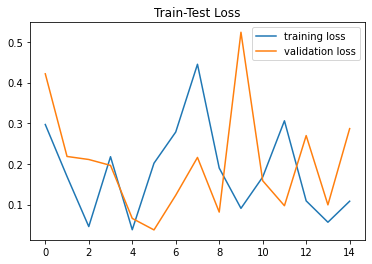

In [13]:
plt.plot(train_losses_resnet, label='training loss')
plt.plot(test_losses_resnet, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [14]:
print(test_correct_resnet)
test_data_size = len(test_data)
print(f'\nTest accuracy (max): {np.array(test_correct_resnet).max().item()*100/test_data_size:.2f}%')

[tensor(255, device='cuda:0'), tensor(272, device='cuda:0'), tensor(269, device='cuda:0'), tensor(269, device='cuda:0'), tensor(266, device='cuda:0'), tensor(261, device='cuda:0'), tensor(272, device='cuda:0'), tensor(268, device='cuda:0'), tensor(278, device='cuda:0'), tensor(272, device='cuda:0'), tensor(274, device='cuda:0'), tensor(269, device='cuda:0'), tensor(266, device='cuda:0'), tensor(275, device='cuda:0'), tensor(270, device='cuda:0')]

Test accuracy (max): 92.67%


In [15]:
#Accuracy for each epoch
for i,acc in enumerate(test_correct_resnet):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/test_data_size:.2f}%')

Test accuracy for ephoch-1: 85.00%
Test accuracy for ephoch-2: 90.67%
Test accuracy for ephoch-3: 89.67%
Test accuracy for ephoch-4: 89.67%
Test accuracy for ephoch-5: 88.67%
Test accuracy for ephoch-6: 87.00%
Test accuracy for ephoch-7: 90.67%
Test accuracy for ephoch-8: 89.33%
Test accuracy for ephoch-9: 92.67%
Test accuracy for ephoch-10: 90.67%
Test accuracy for ephoch-11: 91.33%
Test accuracy for ephoch-12: 89.67%
Test accuracy for ephoch-13: 88.67%
Test accuracy for ephoch-14: 91.67%
Test accuracy for ephoch-15: 90.00%


In [16]:
# Manual evaluation on test set
modelResnet.eval()
corr_pred = 0
act = []
pred = []
for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelResnet(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(labs[i].item())
        pred.append(new_pred.item())
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (Resnet): {corr_pred} ")
print(f"\nTest Set Accuracy (Resnet): {100*corr_pred/len(test_data):.2f}% ")


Correctly Predicted (Resnet): 278 

Test Set Accuracy (Resnet): 92.67% 


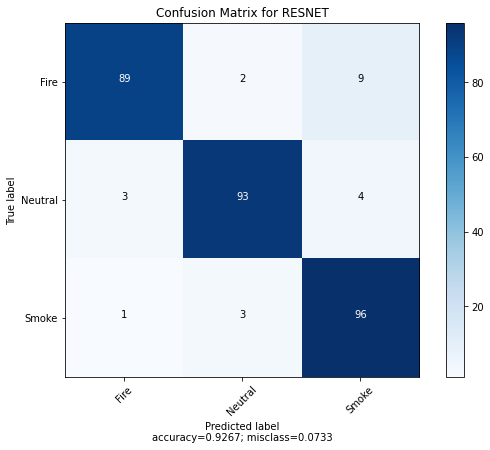

In [17]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for RESNET")

## 3. VGG-16